
# TensorFlow `tf.data` Image Classification — Clean, Annotated Notebook

A modern, production-leaning image pipeline using `tf.data`. This notebook:
- Works whether you have **`root/train|val|test`** or a **single root** with class folders.
- Builds high-throughput, reproducible pipelines.
- Trains a MobileNetV2 classifier with callbacks and optional fine-tuning.
- Provides **clear visualizations**: distributions, class previews, augmentation previews.
- Produces **evaluation visuals**: normalized + count confusion matrices, *error-only* heatmap, styled classification report, ROC curves, and a red/green prediction gallery.
- Saves artifacts (best model, weights, label map, history, classification report).

> Tip: Run cell-by-cell on GPU for best speed. If you don't have `val/`/`test/`, the notebook creates splits from your data.


## 1) Setup & Configuration

In [1]:

# !pip install -q tensorflow matplotlib scikit-learn pandas
import os, math, json, random, pathlib, itertools, time
from datetime import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)

print("TensorFlow:", tf.__version__)

# ---------------- User Config ----------------
# If you have train/val/test dirs: set DATA_ROOT to the parent folder.
# If you only have a single root with class folders, put that path in SINGLE_ROOT and leave DATA_ROOT=None.
DATA_ROOT   = "dataset_train_test_val"   # e.g., has train/val/test (if available)
SINGLE_ROOT = None                       # e.g., "my_root_with_class_folders" (if you don't have train/val/test)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 1337

# Splits used ONLY if we need to split a single root or split train into val/test.
VAL_SPLIT = 0.2
TEST_FRACTION_OF_VAL = 0.5  # half of validation becomes test if we carve out

EPOCHS = 30
BASE_LR = 1e-3
FINE_TUNE_AT = None          # e.g., 100 to unfreeze last 100 layers
CACHE_IN_MEMORY = True
DETERMINISTIC = True

MODEL_DIR = "model_artifacts"
os.makedirs(MODEL_DIR, exist_ok=True)

# Deterministic seeding (best-effort)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# GPU memory growth (avoid full pre-allocation)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
        print("Enabled GPU memory growth.")
    except Exception as e:
        print("Could not set memory growth:", e)

AUTOTUNE = tf.data.AUTOTUNE
PREFETCH = AUTOTUNE


2025-10-31 09:38:06.250063: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-31 09:38:06.250133: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-31 09:38:06.250166: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-31 09:38:06.257436: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow: 2.14.0
Enabled GPU memory growth.


2025-10-31 09:38:08.496174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-31 09:38:08.500309: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-31 09:38:08.500358: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## 2) Data Discovery & Split Logic

In [2]:

def has_dir(pathname):
    p = pathlib.Path(pathname)
    return p.exists() and any(p.iterdir())

def list_classes_from_dir(directory):
    p = pathlib.Path(directory)
    classes = sorted([d.name for d in p.iterdir() if d.is_dir()])
    if not classes:
        raise ValueError(f"No class subfolders found inside: {directory}")
    return classes

def infer_structure(data_root, single_root):
    """Return dict with resolved paths and mode: 'tv' (train/val/test) or 'single'."""
    if single_root and has_dir(single_root):
        return {
            "mode": "single",
            "root": single_root,
            "train": None, "val": None, "test": None
        }
    if data_root and has_dir(data_root):
        t = os.path.join(data_root, "train")
        v = os.path.join(data_root, "val")
        s = os.path.join(data_root, "test")
        return {
            "mode": "tv",
            "root": data_root,
            "train": t if has_dir(t) else data_root,  # fallback to root for split
            "val":   v if has_dir(v) else None,
            "test":  s if has_dir(s) else None
        }
    raise ValueError("Please set DATA_ROOT or SINGLE_ROOT to a valid folder.")

structure = infer_structure(DATA_ROOT, SINGLE_ROOT)
structure


{'mode': 'tv',
 'root': 'dataset_train_test_val',
 'train': 'dataset_train_test_val/train',
 'val': 'dataset_train_test_val/val',
 'test': 'dataset_train_test_val/test'}

## 3) Build `tf.data` Datasets (with automatic split if needed)

In [3]:

def build_datasets(struct):
    if struct["mode"] == "single":
        # One root that has class folders — split here
        class_names = list_classes_from_dir(struct["root"])
        train = tf.keras.utils.image_dataset_from_directory(
            struct["root"], validation_split=VAL_SPLIT, subset="training",
            seed=SEED, labels="inferred", label_mode="int",
            class_names=class_names, image_size=IMG_SIZE,
            batch_size=BATCH_SIZE, shuffle=True
        )
        val_full = tf.keras.utils.image_dataset_from_directory(
            struct["root"], validation_split=VAL_SPLIT, subset="validation",
            seed=SEED, labels="inferred", label_mode="int",
            class_names=class_names, image_size=IMG_SIZE,
            batch_size=BATCH_SIZE, shuffle=False
        )
        # carve out test from validation
        vb = len(val_full)
        tb = max(1, int(round(vb * TEST_FRACTION_OF_VAL)))
        test = val_full.take(tb)
        val  = val_full.skip(tb)
        return class_names, train, val, test

    # 'tv' mode: train/val/test dirs (any missing ones are derived)
    class_names = list_classes_from_dir(struct["train"])
    if struct["val"]:
        train = tf.keras.utils.image_dataset_from_directory(
            struct["train"], seed=SEED, labels="inferred", label_mode="int",
            class_names=class_names, image_size=IMG_SIZE,
            batch_size=BATCH_SIZE, shuffle=True
        )
        val = tf.keras.utils.image_dataset_from_directory(
            struct["val"], seed=SEED, labels="inferred", label_mode="int",
            class_names=class_names, image_size=IMG_SIZE,
            batch_size=BATCH_SIZE, shuffle=False
        )
    else:
        # Split from train
        train = tf.keras.utils.image_dataset_from_directory(
            struct["train"], validation_split=VAL_SPLIT, subset="training",
            seed=SEED, labels="inferred", label_mode="int",
            class_names=class_names, image_size=IMG_SIZE,
            batch_size=BATCH_SIZE, shuffle=True
        )
        val = tf.keras.utils.image_dataset_from_directory(
            struct["train"], validation_split=VAL_SPLIT, subset="validation",
            seed=SEED, labels="inferred", label_mode="int",
            class_names=class_names, image_size=IMG_SIZE,
            batch_size=BATCH_SIZE, shuffle=False
        )

    if struct["test"]:
        test = tf.keras.utils.image_dataset_from_directory(
            struct["test"], seed=SEED, labels="inferred", label_mode="int",
            class_names=class_names, image_size=IMG_SIZE,
            batch_size=BATCH_SIZE, shuffle=False
        )
    else:
        # carve out small test from val if not provided
        vb = len(val)
        tb = max(1, int(round(vb * TEST_FRACTION_OF_VAL)))
        test = val.take(tb)
        val  = val.skip(tb)

    return class_names, train, val, test

CLASS_NAMES, train_ds_raw, val_ds_raw, test_ds_raw = build_datasets(structure)
NUM_CLASSES = len(CLASS_NAMES)
ID_TO_CLASS = {i:c for i,c in enumerate(CLASS_NAMES)}
CLASS_TO_ID = {c:i for i,c in ID_TO_CLASS.items()}

print("Classes:", CLASS_NAMES)
print("Batches:", len(train_ds_raw), len(val_ds_raw), len(test_ds_raw))


Found 326 files belonging to 4 classes.


2025-10-31 09:38:08.576813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-31 09:38:08.576903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-31 09:38:08.576934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-31 09:38:08.713117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-31 09:38:08.713187: I tensorflow/compile

Found 92 files belonging to 4 classes.
Found 49 files belonging to 4 classes.
Classes: ['Bacterial_Pneu', 'COVID', 'Normal', 'Viral_Pneu']
Batches: 11 3 2


## 4) tf.data Options, Class Counts, and Performance Wrapping

In [4]:

# Options
opt = tf.data.Options()
opt.experimental_deterministic = DETERMINISTIC
train_ds_raw = train_ds_raw.with_options(opt)
val_ds_raw   = val_ds_raw.with_options(opt)
test_ds_raw  = test_ds_raw.with_options(opt)

def count_by_class(ds):
    counts = np.zeros(NUM_CLASSES, dtype=int)
    for _, y in ds.unbatch():
        counts[int(y.numpy())] += 1
    return counts

train_counts = count_by_class(train_ds_raw)
val_counts   = count_by_class(val_ds_raw)
test_counts  = count_by_class(test_ds_raw)

def wrap_pipeline(ds, training=False):
    ds = ds.cache() if CACHE_IN_MEMORY else ds
    if training:
        ds = ds.shuffle(buffer_size=min(1000, int(train_counts.sum())), seed=SEED,
                        reshuffle_each_iteration=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = wrap_pipeline(train_ds_raw, training=True)
val_ds   = wrap_pipeline(val_ds_raw, training=False)
test_ds  = wrap_pipeline(test_ds_raw, training=False)


## 5) Dataset Distribution & Visual Previews

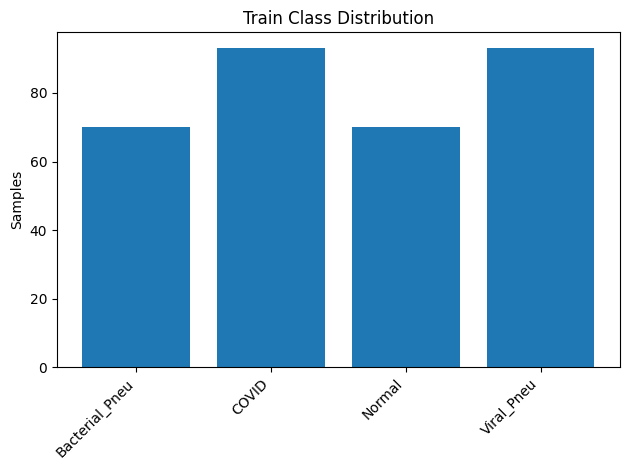

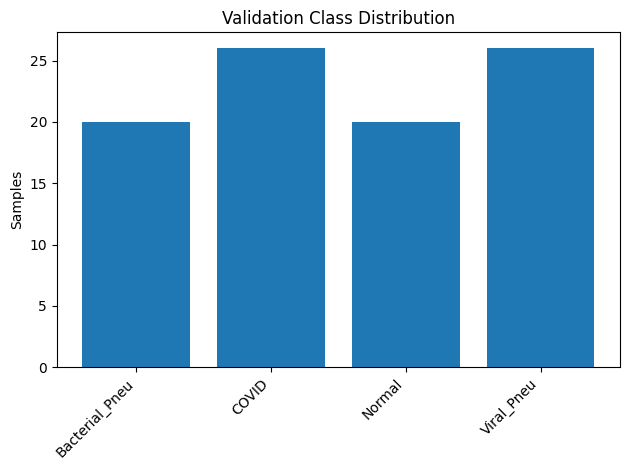

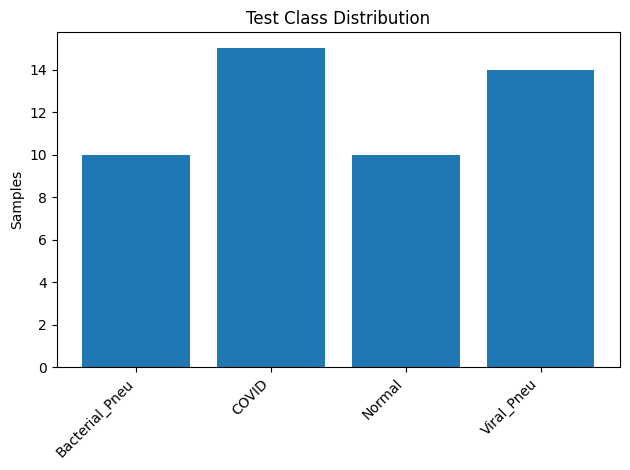

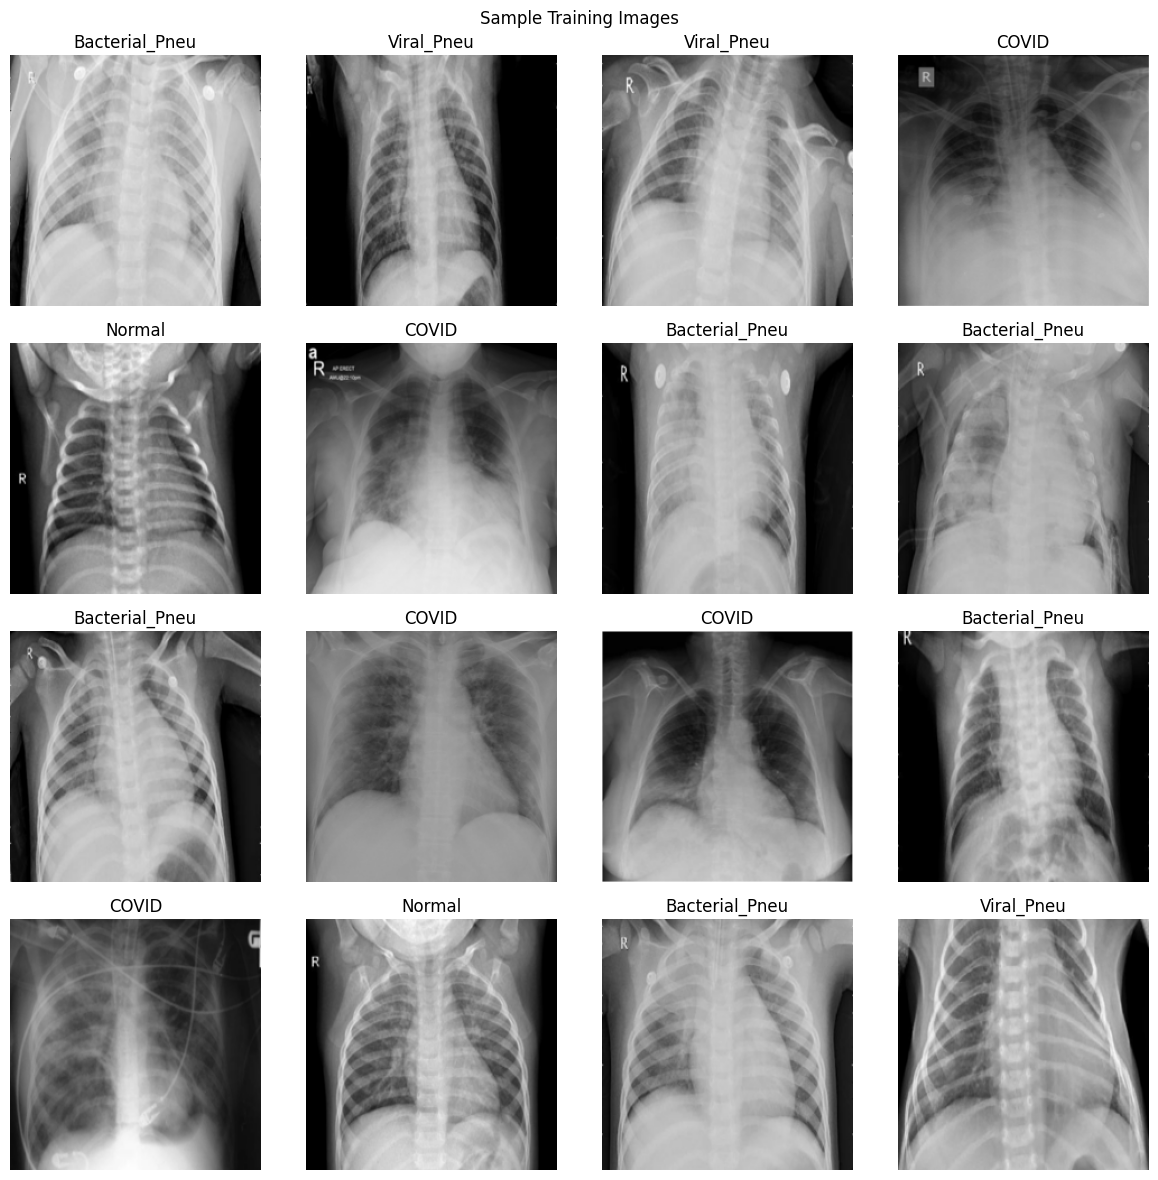

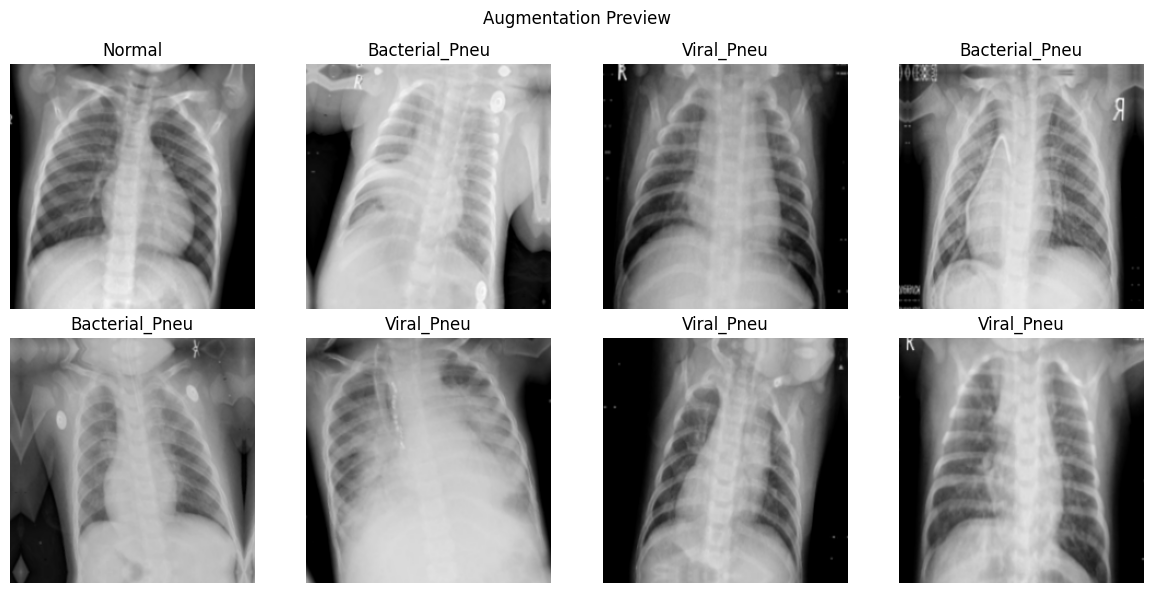

In [5]:

def plot_distribution(counts, title):
    plt.figure()
    plt.bar(CLASS_NAMES, counts)
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Samples")
    plt.tight_layout(); plt.show()

plot_distribution(train_counts, "Train Class Distribution")
plot_distribution(val_counts,   "Validation Class Distribution")
plot_distribution(test_counts,  "Test Class Distribution")

def show_batch(ds, title, max_images=16):
    images, labels = next(iter(ds))
    n = min(max_images, images.shape[0])
    cols = 4
    rows = math.ceil(n/cols)
    plt.figure(figsize=(cols*3, rows*3))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(ID_TO_CLASS[int(labels[i].numpy())])
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout(); plt.show()

show_batch(train_ds_raw, "Sample Training Images")

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="augmentation")

def visualize_augmentations(ds, n=8):
    imgs, labels = next(iter(ds))
    imgs = tf.cast(imgs[:n], tf.float32)
    augmented = data_augmentation(imgs)
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(2, n//2, i+1)
        plt.imshow(tf.cast(tf.clip_by_value(augmented[i], 0, 255), tf.uint8).numpy())
        plt.title(ID_TO_CLASS[int(labels[i].numpy())])
        plt.axis("off")
    plt.suptitle("Augmentation Preview")
    plt.tight_layout(); plt.show()

visualize_augmentations(train_ds_raw, n=8)


## 6) Build Model (MobileNetV2)

In [6]:

normalization = tf.keras.layers.Rescaling(1./255)

base = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base.trainable = False  # Phase 1

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = normalization(x)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x*255.0)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs, name="mobilenetv2_classifier")

model.compile(optimizer=tf.keras.optimizers.Adam(BASE_LR),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

# Save label map for downstream usage
with open(os.path.join(MODEL_DIR, "label_map.json"), "w") as f:
    json.dump({int(k): v for k, v in {i:c for i,c in enumerate(CLASS_NAMES)}.items()}, f, indent=2)
print("Saved label_map.json")


Model: "mobilenetv2_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 tf.math.multiply (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224

## 7) Train (Callbacks, Class Weights)

In [7]:
# --- Checkpoints: save weights via callback; save full model manually after fit ---
ckpt_weights = os.path.join(MODEL_DIR, "best_ckpt.weights")
best_model_path = os.path.join(MODEL_DIR, "best_model.keras")  # we'll save manually after fit

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        ckpt_weights,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,   # <-- keep weights only in the callback
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=6, restore_best_weights=True, verbose=1
    ),
]

# Class weights (unchanged)
total = train_counts.sum()
class_weight = {i: float(total / (NUM_CLASSES * max(1, train_counts[i])))
                for i in range(NUM_CLASSES)}
print("Class weights:", class_weight)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)

# Save training history
hist_df = pd.DataFrame(history.history)
hist_csv = os.path.join(MODEL_DIR, "history.csv")
hist_df.to_csv(hist_csv, index=False)
print("Saved:", hist_csv)

# Ensure best weights are loaded, then save full model in the native .keras format
# Ensure best weights are loaded (from the callback checkpoint)
model.load_weights(ckpt_weights)

# --- Save the full model safely (no h5py) ---
# Option A (Keras 3 serving-friendly export):
best_savedmodel_dir = os.path.join(MODEL_DIR, "best_savedmodel")
import shutil
if os.path.isdir(best_savedmodel_dir):
    shutil.rmtree(best_savedmodel_dir)  # clean if exists

try:
    # Keras 3 provides `export` for inference/serving graphs; never touches h5py
    model.export(best_savedmodel_dir)
    print("Exported model (SavedModel) to:", best_savedmodel_dir)
except AttributeError:
    # Fallback for environments without `model.export`:
    import tensorflow as tf
    tf.saved_model.save(model, best_savedmodel_dir)
    print("Saved model (SavedModel) to:", best_savedmodel_dir)

# (Optional) If you still want a .keras file and your env supports native Keras format:
# Try it guarded; if it fails we already have SavedModel above.
best_model_path = os.path.join(MODEL_DIR, "best_model.keras")
try:
    if os.path.exists(best_model_path):
        os.remove(best_model_path)
    model.save(best_model_path)  # native Keras format (no HDF5)
    print("Also saved native Keras model to:", best_model_path)
except Exception as e:
    print("Native .keras save skipped due to:", repr(e))

Class weights: {0: 1.1642857142857144, 1: 0.8763440860215054, 2: 1.1642857142857144, 3: 0.8763440860215054}
Epoch 1/30


2025-10-31 09:38:16.639683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902


 1/11 [=>............................] - ETA: 38s - loss: 1.7313 - accuracy: 0.1250

2025-10-31 09:38:18.130258: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2364b740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-31 09:38:18.130319: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2025-10-31 09:38:18.135050: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-31 09:38:18.212018: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/11 [==========================>...] - ETA: 0s - loss: 1.5164 - accuracy: 0.3469
Epoch 1: val_accuracy improved from -inf to 0.66304, saving model to model_artifacts/best_ckpt.weights
11/11 [==============================] - 7s 271ms/step - loss: 1.4674 - accuracy: 0.3620 - val_loss: 0.9139 - val_accuracy: 0.6630 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.9828 - accuracy: 0.6074
Epoch 2: val_accuracy improved from 0.66304 to 0.78261, saving model to model_artifacts/best_ckpt.weights
11/11 [==============================] - 1s 85ms/step - loss: 0.9828 - accuracy: 0.6074 - val_loss: 0.7019 - val_accuracy: 0.7826 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.8038 - accuracy: 0.6564
Epoch 3: val_accuracy improved from 0.78261 to 0.81522, saving model to model_artifacts/best_ckpt.weights
11/11 [==============================] - 1s 77ms/step - loss: 0.8038 - accuracy: 0.6564 - val_loss: 0.6094 - val_accuracy: 0.81

INFO:tensorflow:Assets written to: model_artifacts/best_savedmodel/assets


Saved artifact at 'model_artifacts/best_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: float32 Tensor, shape=(None, 224, 224, 3)
  Returns:
    float32 Tensor, shape=(None, 4)
Exported model (SavedModel) to: model_artifacts/best_savedmodel
Native .keras save skipped due to: TypeError("Argument 'path' must not be None")


In [8]:
# Ensure best weights are loaded (from the callback checkpoint)
model.load_weights(ckpt_weights)

# --- Save the full model safely (no h5py) ---
# Option A (Keras 3 serving-friendly export):
best_savedmodel_dir = os.path.join(MODEL_DIR, "best_savedmodel")
import shutil
if os.path.isdir(best_savedmodel_dir):
    shutil.rmtree(best_savedmodel_dir)  # clean if exists

try:
    # Keras 3 provides `export` for inference/serving graphs; never touches h5py
    model.export(best_savedmodel_dir)
    print("Exported model (SavedModel) to:", best_savedmodel_dir)
except AttributeError:
    # Fallback for environments without `model.export`:
    import tensorflow as tf
    tf.saved_model.save(model, best_savedmodel_dir)
    print("Saved model (SavedModel) to:", best_savedmodel_dir)

# (Optional) If you still want a .keras file and your env supports native Keras format:
# Try it guarded; if it fails we already have SavedModel above.
best_model_path = os.path.join(MODEL_DIR, "best_model.keras")
try:
    if os.path.exists(best_model_path):
        os.remove(best_model_path)
    model.save(best_model_path)  # native Keras format (no HDF5)
    print("Also saved native Keras model to:", best_model_path)
except Exception as e:
    print("Native .keras save skipped due to:", repr(e))

INFO:tensorflow:Assets written to: model_artifacts/best_savedmodel/assets


INFO:tensorflow:Assets written to: model_artifacts/best_savedmodel/assets


Saved artifact at 'model_artifacts/best_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: float32 Tensor, shape=(None, 224, 224, 3)
  Returns:
    float32 Tensor, shape=(None, 4)
Exported model (SavedModel) to: model_artifacts/best_savedmodel
Native .keras save skipped due to: TypeError("Argument 'path' must not be None")


## 8) Training Curves

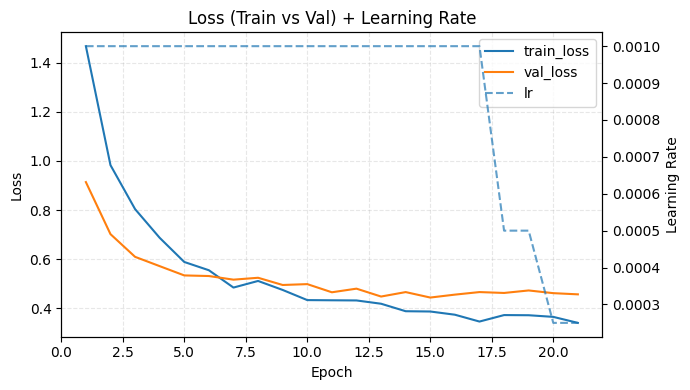

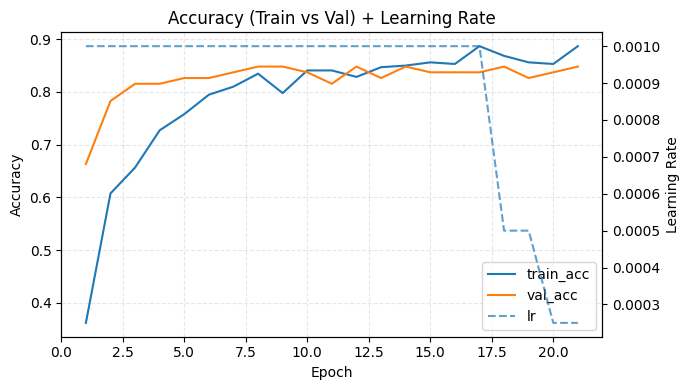

In [9]:
def plot_history(h, save_dir=None):
    """
    Plots train+val Loss on one figure and train+val Accuracy on another,
    with Learning Rate overlaid as a secondary y-axis on BOTH figures.
    Optionally saves PNGs if save_dir is provided.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from pathlib import Path

    hist = h.history if hasattr(h, "history") else h
    epochs = np.arange(1, len(hist.get("loss", [])) + 1)

    has_val_loss = "val_loss" in hist
    has_val_acc  = "val_accuracy" in hist
    has_lr       = "lr" in hist

    if save_dir:
        Path(save_dir).mkdir(parents=True, exist_ok=True)

    # ---------- LOSS ----------
    fig, ax1 = plt.subplots(figsize=(7,4))
    ax1.plot(epochs, hist["loss"], label="train_loss")
    if has_val_loss:
        ax1.plot(epochs, hist["val_loss"], label="val_loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title("Loss (Train vs Val) + Learning Rate")
    ax1.grid(True, linestyle="--", alpha=0.3)

    lines1, labels1 = ax1.get_legend_handles_labels()
    if has_lr:
        ax2 = ax1.twinx()
        ax2.plot(epochs, hist["lr"], linestyle="--", alpha=0.7, label="lr")
        ax2.set_ylabel("Learning Rate")
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines = lines1 + lines2
        labels = labels1 + labels2
    else:
        lines, labels = lines1, labels1

    ax1.legend(lines, labels, loc="best")
    fig.tight_layout()
    if save_dir:
        fig.savefig(f"{save_dir}/loss_lr.png", dpi=150)
    plt.show()

    # ---------- ACCURACY ----------
    if "accuracy" in hist:
        fig, ax1 = plt.subplots(figsize=(7,4))
        ax1.plot(epochs, hist["accuracy"], label="train_acc")
        if has_val_acc:
            ax1.plot(epochs, hist["val_accuracy"], label="val_acc")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Accuracy")
        ax1.set_title("Accuracy (Train vs Val) + Learning Rate")
        ax1.grid(True, linestyle="--", alpha=0.3)

        lines1, labels1 = ax1.get_legend_handles_labels()
        if has_lr:
            ax2 = ax1.twinx()
            ax2.plot(epochs, hist["lr"], linestyle="--", alpha=0.7, label="lr")
            ax2.set_ylabel("Learning Rate")
            lines2, labels2 = ax2.get_legend_handles_labels()
            lines = lines1 + lines2
            labels = labels1 + labels2
        else:
            lines, labels = lines1, labels1

        ax1.legend(lines, labels, loc="best")
        fig.tight_layout()
        if save_dir:
            fig.savefig(f"{save_dir}/accuracy_lr.png", dpi=150)
        plt.show()
    else:
        print("No 'accuracy' in history; skipping accuracy plot.")

# use it
plot_history(history, save_dir=MODEL_DIR)  # or plot_history(history)


## 9) (Optional) Fine-tuning

In [10]:

if FINE_TUNE_AT is not None:
    base.trainable = True
    for layer in base.layers[:-FINE_TUNE_AT]:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(BASE_LR/10),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    history_ft = model.fit(
        train_ds, validation_data=val_ds,
        epochs=max(5, EPOCHS//3), callbacks=callbacks,
        class_weight=class_weight, verbose=1
    )
    plot_history(history_ft)


## 10) Evaluation: Predictions & Metrics

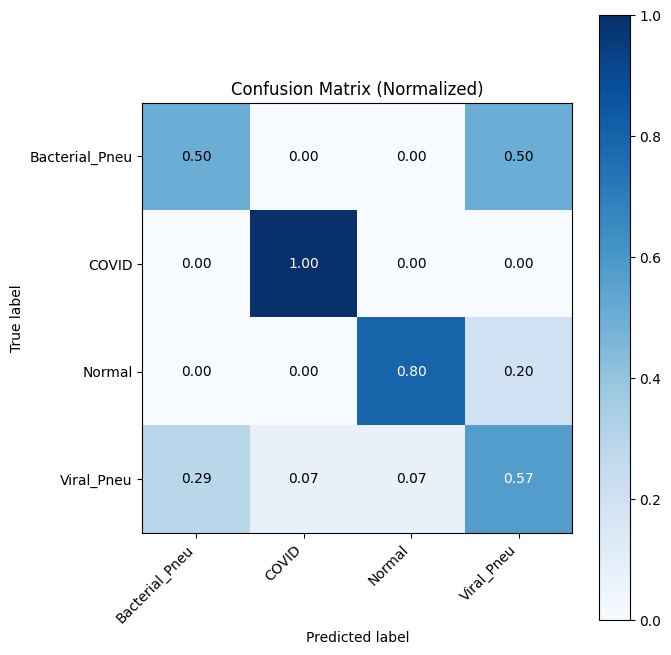

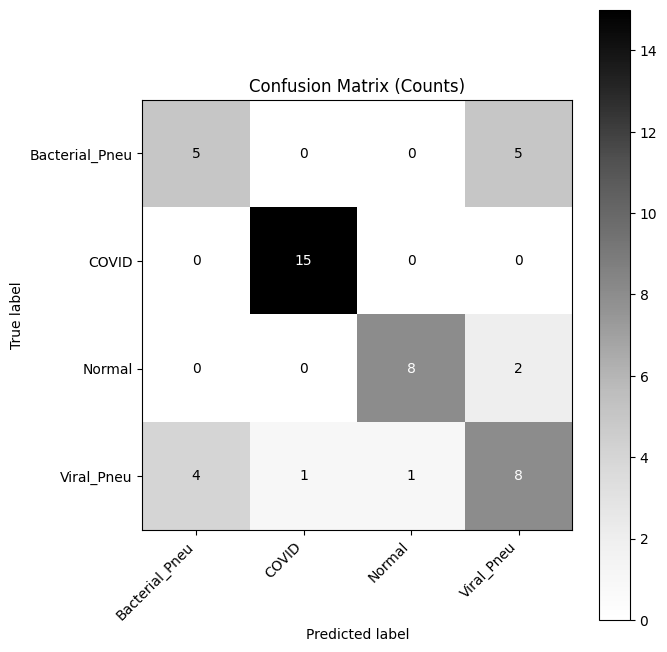

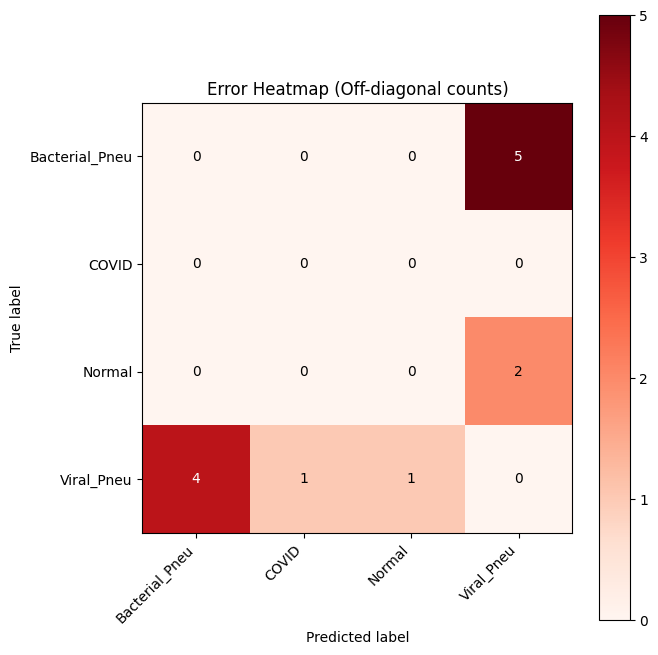

,precision,recall,f1-score,support
Bacterial_Pneu,0.556,0.500,0.526,10.000
COVID,0.938,1.000,0.968,15.000
Normal,0.889,0.800,0.842,10.000
Viral_Pneu,0.533,0.571,0.552,14.000
accuracy,0.735,0.735,0.735,0.735
macro avg,0.729,0.718,0.722,49.000
weighted avg,0.734,0.735,0.733,49.000


Classification Report (text)
                precision    recall  f1-score   support

Bacterial_Pneu     0.5556    0.5000    0.5263        10
         COVID     0.9375    1.0000    0.9677        15
        Normal     0.8889    0.8000    0.8421        10
    Viral_Pneu     0.5333    0.5714    0.5517        14

      accuracy                         0.7347        49
     macro avg     0.7288    0.7179    0.7220        49
  weighted avg     0.7342    0.7347    0.7332        49

Saved: model_artifacts/classification_report.csv
Macro ROC–AUC: 0.8864


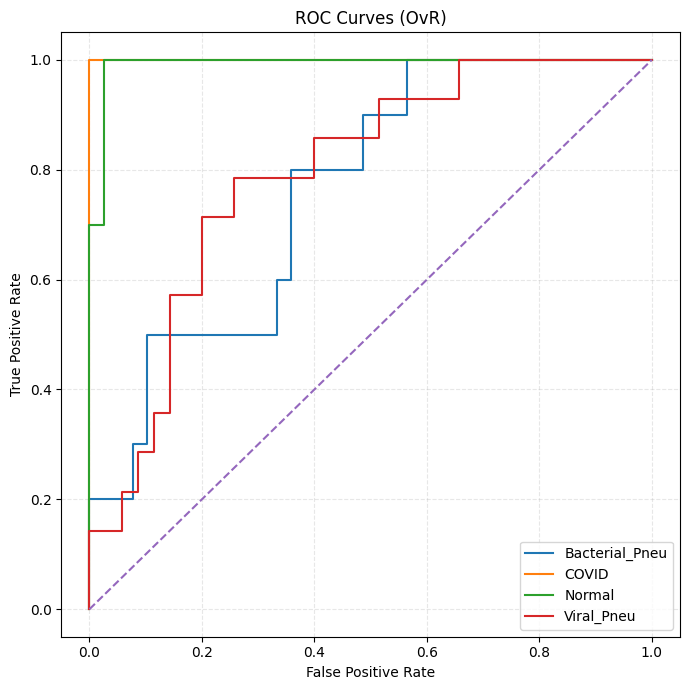

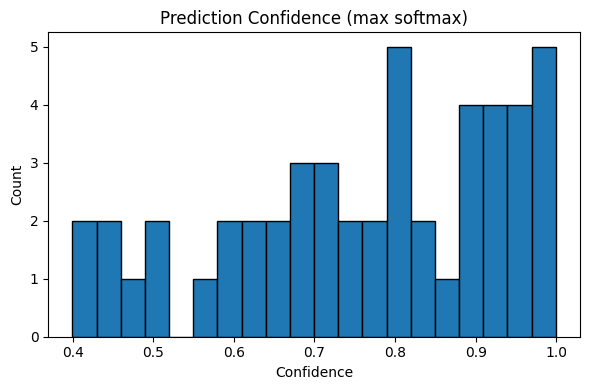

In [11]:

def collect_preds(ds):
    y_true, y_prob = [], []
    for xb, yb in ds:
        probs = model.predict(xb, verbose=0)
        y_prob.append(probs)
        y_true.append(yb.numpy())
    y_prob = np.concatenate(y_prob, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.argmax(y_prob, axis=1)
    return y_true, y_pred, y_prob

eval_ds = test_ds if len(list(test_ds_raw)) > 0 else val_ds
y_true, y_pred, y_prob = collect_preds(eval_ds)

# Confusion matrices
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
cm_norm = cm.astype("float")
cm_norm = cm_norm / np.maximum(cm_norm.sum(axis=1, keepdims=True), 1e-12)

def plot_cm(matrix, title, cmap, fmt):
    plt.figure(figsize=(7,7))
    plt.imshow(matrix, interpolation="nearest", cmap=cmap)
    plt.title(title); plt.colorbar()
    ticks = np.arange(NUM_CLASSES)
    plt.xticks(ticks, CLASS_NAMES, rotation=45, ha="right")
    plt.yticks(ticks, CLASS_NAMES)
    thresh = np.nanmax(matrix) / 2.0 if np.isfinite(matrix).any() else 0.5
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            txt = f"{val:{fmt}}"
            plt.text(j, i, txt, ha="center", va="center",
                     color="white" if val > thresh else "black")
    plt.ylabel("True label"); plt.xlabel("Predicted label")
    plt.tight_layout(); plt.show()

plot_cm(cm_norm, "Confusion Matrix (Normalized)", cmap="Blues", fmt=".2f")
plot_cm(cm,      "Confusion Matrix (Counts)",     cmap="Greys", fmt="d")

# Error-only heatmap (zeroed diagonal, highlights misclassifications)
err_only = cm.astype(float)
np.fill_diagonal(err_only, 0.0)
plot_cm(err_only, "Error Heatmap (Off-diagonal counts)", cmap="Reds", fmt=".0f")

# Classification report (styled + CSV)
report_dict = classification_report(
    y_true, y_pred, target_names=CLASS_NAMES, digits=4, output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose()

from IPython.display import display
display(report_df.round(3).style.format("{:.3f}")
        .set_table_attributes('style="width:70%; margin-left:auto; margin-right:auto"')
        .set_caption("Classification Report"))
print("Classification Report (text)")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

cr_csv = os.path.join(MODEL_DIR, "classification_report.csv")
report_df.to_csv(cr_csv); print("Saved:", cr_csv)

# ROC–AUC per class (OvR) & macro
try:
    y_true_oh = tf.one_hot(y_true, depth=NUM_CLASSES).numpy()
    auc_macro = roc_auc_score(y_true_oh, y_prob, average="macro", multi_class="ovr")
    print(f"Macro ROC–AUC: {auc_macro:.4f}")
    plt.figure(figsize=(7,7))
    for i, cls in enumerate(CLASS_NAMES):
        fpr, tpr, _ = roc_curve(y_true_oh[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, label=cls)
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (OvR)"); plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout(); plt.show()
except Exception as e:
    print("ROC–AUC skipped:", e)

# Confidence histogram
max_conf = y_prob.max(axis=1)
plt.figure(figsize=(6,4))
plt.hist(max_conf, bins=20, edgecolor="black")
plt.title("Prediction Confidence (max softmax)")
plt.xlabel("Confidence"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


## 11) Red/Green Prediction Gallery (Green=Correct, Red=Wrong)

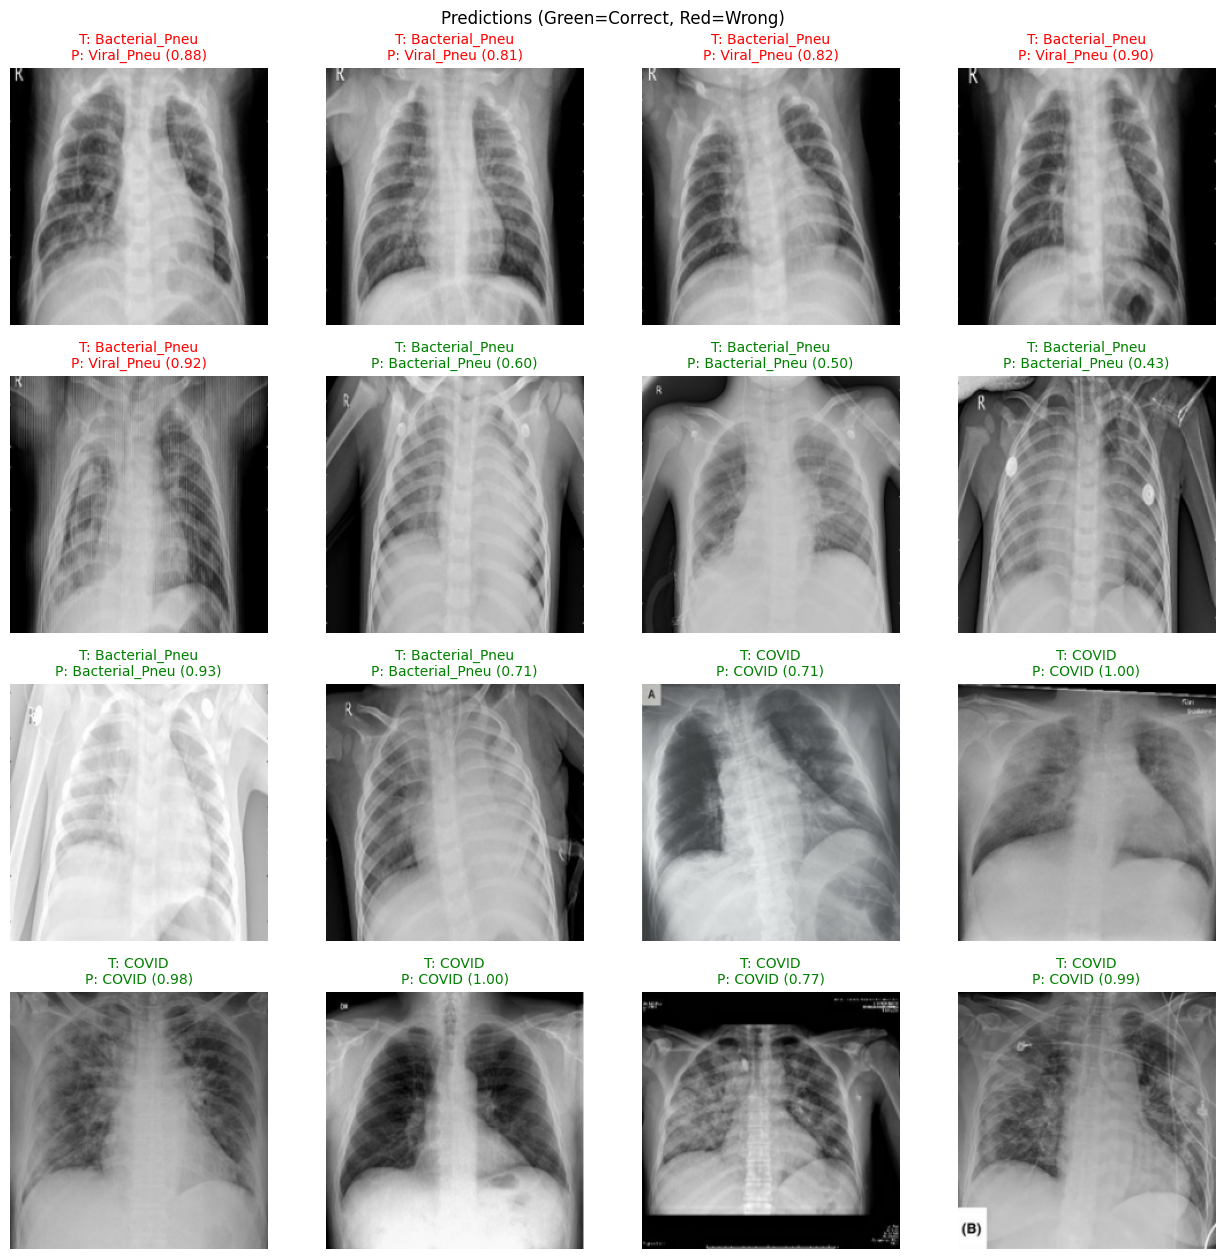

In [12]:

def class_name(idx):
    return ID_TO_CLASS[int(idx)]

def collect_pred_samples(ds, max_keep=24):
    imgs, y_true_s, y_pred_s, conf = [], [], [], []
    for xb, yb in ds:
        probs = model.predict(xb, verbose=0)
        yhat  = np.argmax(probs, axis=1)
        cmax  = probs[np.arange(len(yhat)), yhat]
        for i in range(len(yhat)):
            if len(imgs) >= max_keep: break
            imgs.append(xb[i].numpy().astype("uint8"))
            y_true_s.append(int(yb.numpy()[i]))
            y_pred_s.append(int(yhat[i]))
            conf.append(float(cmax[i]))
        if len(imgs) >= max_keep: break
    imgs = np.array(imgs); y_true_s = np.array(y_true_s); y_pred_s = np.array(y_pred_s); conf = np.array(conf)
    wrong = (y_true_s != y_pred_s)
    order = np.argsort(~wrong)  # misclassified first
    return imgs[order], y_true_s[order], y_pred_s[order], conf[order], wrong[order]

def show_pred_gallery(ds, max_keep=16, title="Predictions (Green=Correct, Red=Wrong)"):
    imgs, t, p, c, wrong = collect_pred_samples(ds, max_keep=max_keep)
    n = len(imgs)
    if n == 0:
        print("No samples found to visualize."); return
    cols = 4; rows = math.ceil(n/cols)
    plt.figure(figsize=(cols*3.2, rows*3.2))
    for i in range(n):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(imgs[i])
        ok = not wrong[i]
        color = "green" if ok else "red"
        ax.set_title(f"T: {class_name(t[i])}\nP: {class_name(p[i])} ({c[i]:.2f})",
                     color=color, fontsize=10)
        ax.axis("off")
        # Colored border for clarity
        for spine in ax.spines.values():
            spine.set_edgecolor(color); spine.set_linewidth(2.5)
    plt.suptitle(title, fontsize=12); plt.tight_layout(); plt.show()

eval_for_gallery = test_ds if len(list(test_ds_raw)) > 0 else val_ds
show_pred_gallery(eval_for_gallery, max_keep=16)


## 12) Save/Load Model & Single-Image Prediction

In [13]:

# # Save final model (SavedModel) and re-loadable .keras already saved in callbacks
# saved_path = os.path.join(MODEL_DIR, "saved_model")
# model.save(saved_path)
# print("Saved SavedModel to:", saved_path)

# reloaded = tf.keras.models.load_model(os.path.join(MODEL_DIR, "best_model.keras"))
# print("Reloaded best model (.keras).")

# def load_image_for_infer(path, img_size=IMG_SIZE):
#     img = tf.keras.utils.load_img(path, target_size=img_size)
#     arr = tf.keras.utils.img_to_array(img)
#     arr = tf.expand_dims(arr, 0)  # [1,H,W,3]
#     return arr

# def predict_image(path):
#     arr = load_image_for_infer(path)
#     arr = tf.keras.layers.Rescaling(1./255)(arr)
#     arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr*255.0)
#     probs = reloaded.predict(arr, verbose=0)[0]
#     pred_id = int(np.argmax(probs)); pred_cls = ID_TO_CLASS[pred_id]
#     conf = float(probs[pred_id])
#     print(f"Image: {path}\nPredicted: {pred_cls} (confidence: {conf:.3f})")
#     img = tf.keras.utils.load_img(path, target_size=IMG_SIZE)
#     plt.figure(); plt.imshow(img); plt.title(f"{pred_cls} ({conf:.1%})"); plt.axis("off"); plt.show()

# # Example (change path to a real image on your machine):
# # predict_image("dataset_train_test_val/test/<ClassName>/image.jpg")


In [14]:
import matplotlib.pyplot as plt
from PIL import Image

SAVEDMODEL_DIR = "model_artifacts/best_savedmodel"

# 1) Load SavedModel
loaded = tf.saved_model.load(SAVEDMODEL_DIR)

# 2) Pick the right signature (serving function)
def get_infer_signature(loaded_obj):
    # Common names are 'serve' (Keras 3 export) and 'serving_default' (TF SavedModel)
    keys = list(loaded_obj.signatures.keys())
    if "serve" in loaded_obj.signatures:
        return loaded_obj.signatures["serve"]
    if "serving_default" in loaded_obj.signatures:
        return loaded_obj.signatures["serving_default"]
    # fallback: take the first available signature
    return loaded_obj.signatures[keys[0]]

infer = get_infer_signature(loaded)
print("Available signatures:", list(loaded.signatures.keys()))
print("Using signature:", infer)



# --- Utility: get the correct output key from the SavedModel signature ---
def _get_output_key(sig):
    if hasattr(sig, "structured_outputs"):
        for k in ["output_0", "predictions", "probabilities", "softmax", "outputs"]:
            if k in sig.structured_outputs:
                return k
        # fallback: first key
        keys = list(sig.structured_outputs.keys())
        if keys:
            return keys[0]
    raise KeyError("Could not find an output key in signature. "
                   f"Available: {list(getattr(sig, 'structured_outputs', {}).keys())}")

def infer_true_label_from_path(path):
    parts = os.path.normpath(path).split(os.sep)
    # pick the parent directory name as class name; adjust if your layout differs
    return parts[-2] if len(parts) >= 2 else None


OUTPUT_KEY = _get_output_key(infer)

def load_img_for_savedmodel(path, img_size=IMG_SIZE):
    img = Image.open(path).convert("RGB").resize(img_size)
    arr = np.array(img, dtype=np.float32)   # model expects float32 [0..255]
    arr = np.expand_dims(arr, 0)            # [1,H,W,3]
    return img, arr

def predict_with_savedmodel(
    path,
    show_topk=5,
    true_label=None,
    save_fig_path=None,
):
    if true_label is None:
        true_label = infer_true_label_from_path(path)  # optional auto-gt

    img, arr = load_img_for_savedmodel(path)

    # Run SavedModel and pick output key
    try:
        outs = infer(tf.constant(arr))[OUTPUT_KEY].numpy()
    except KeyError as e:
        print("Output key issue:", e)
        print("Try printing infer.structured_outputs to inspect available keys:")
        print(infer.structured_outputs)
        return

    probs = outs[0]
    pred_id = int(np.argmax(probs))
    pred_cls = id_to_class[pred_id]
    conf = float(probs[pred_id])

    title_color = "black"
    if true_label is not None:
        title_color = "green" if str(true_label) == str(pred_cls) else "red"

    # Prepare top-k
    k = min(show_topk, len(probs))
    topk_idx = np.argsort(-probs)[:k]
    topk_labels = [id_to_class[int(i)] for i in topk_idx]
    topk_values = probs[topk_idx]

    # --- Figure: side-by-side image + bar chart ---
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    ax_img, ax_bar = axes

    # Left: image with prediction
    ax_img.imshow(img)
    title_extra = f" | GT: {true_label}" if true_label is not None else ""
    ax_img.set_title(f"Pred: {pred_cls} ({conf:.1%}){title_extra}", color=title_color)
    ax_img.axis("off")

    # Right: top-k bars
    ax_bar.barh(range(k), topk_values[::-1])
    ax_bar.set_yticks(range(k))
    ax_bar.set_yticklabels(topk_labels[::-1])
    ax_bar.set_xlabel("Probability")
    ax_bar.set_xlim(0, 1)
    ax_bar.set_title("Top-k probabilities")
    for i, v in enumerate(topk_values[::-1]):
        ax_bar.text(min(0.98, v) + 0.01*(v<0.98), i, f"{v:.2f}", va="center")

    fig.tight_layout()
    if save_fig_path:
        os.makedirs(os.path.dirname(save_fig_path), exist_ok=True)
        fig.savefig(save_fig_path, dpi=150)
        print("Saved figure to:", save_fig_path)
    plt.show()

    # concise text summary
    print(f"Top-1: {pred_cls}  (conf: {conf:.3f})")
    for i in range(k):
        idx = topk_idx[i]
        print(f"{id_to_class[int(idx)]:20s} : {probs[int(idx)]:.3f}")
        
# # Example usage:
# # If you know the ground-truth class for coloring (optional), pass it via true_label="Viral_Pneu" etc.
# predict_with_savedmodel(
#     "dataset_train_test_val/test/Viral_Pneu/Pneumonia-Viral (37).png",
#     show_topk=5,
#     true_label=None,  # leave None to auto-infer from folder name
#     save_fig_path=os.path.join(MODEL_DIR, "inference_preview.png")
# )


Available signatures: ['serve', 'serving_default']
Using signature: ConcreteFunction signature_wrapper___call__(*, input_2)
  Args:
    input_2: float32 Tensor, shape=(None, 224, 224, 3)
  Returns:
    {'output_0': <1>}
      <1>: float32 Tensor, shape=(None, 4)


In [15]:
def _get_output_key(sig):
    if hasattr(sig, "structured_outputs"):
        for k in ["output_0", "predictions", "probabilities", "softmax", "outputs"]:
            if k in sig.structured_outputs:
                return k
        keys = list(sig.structured_outputs.keys())
        if keys:
            return keys[0]
    raise KeyError("Could not find an output key in signature.")

OUTPUT_KEY = _get_output_key(infer)

def load_img_for_savedmodel(path, img_size=IMG_SIZE):
    from PIL import Image
    img = Image.open(path).convert("RGB").resize(img_size)
    arr = np.array(img, dtype=np.float32)   # model expects float32 [0..255]
    arr = np.expand_dims(arr, 0)            # [1,H,W,3]
    return img, arr

def predict_with_savedmodel(
    path,
    show_topk=5,
    true_label=None,
    save_fig_path=None,
):
    if true_label is None:
        # optional: infer GT from parent folder
        parts = os.path.normpath(path).split(os.sep)
        true_label = parts[-2] if len(parts) >= 2 else None

    img, arr = load_img_for_savedmodel(path)

    outs = infer(tf.constant(arr))[OUTPUT_KEY].numpy()
    probs = outs[0]
    pred_id = int(np.argmax(probs))
    pred_cls = ID_TO_CLASS[pred_id]
    conf = float(probs[pred_id])

    # top-k
    k = min(show_topk, len(probs))
    topk_idx = np.argsort(-probs)[:k]
    topk_labels = [ID_TO_CLASS[int(i)] for i in topk_idx]
    topk_values = probs[topk_idx]

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    ax_img, ax_bar = axes
    ax_img.imshow(img)
    color = "black" if true_label is None else ("green" if str(true_label) == str(pred_cls) else "red")
    ax_img.set_title(f"Pred: {pred_cls} ({conf:.1%})" + (f" | GT: {true_label}" if true_label else ""), color=color)
    ax_img.axis("off")

    ax_bar.barh(range(k), topk_values[::-1])
    ax_bar.set_yticks(range(k))
    ax_bar.set_yticklabels(topk_labels[::-1])
    ax_bar.set_xlabel("Probability"); ax_bar.set_xlim(0, 1)
    ax_bar.set_title("Top-k probabilities")
    for i, v in enumerate(topk_values[::-1]):
        ax_bar.text(min(0.98, v) + 0.01*(v<0.98), i, f"{v:.2f}", va="center")

    fig.tight_layout()
    if save_fig_path:
        os.makedirs(os.path.dirname(save_fig_path), exist_ok=True)
        fig.savefig(save_fig_path, dpi=150)
        print("Saved figure to:", save_fig_path)
    plt.show()

    print(f"Top-1: {pred_cls}  (conf: {conf:.3f})")
    for i in range(k):
        idx = topk_idx[i]
        print(f"{ID_TO_CLASS[int(idx)]:20s} : {probs[int(idx)]:.3f}")

Saved figure to: model_artifacts/inference_preview.png


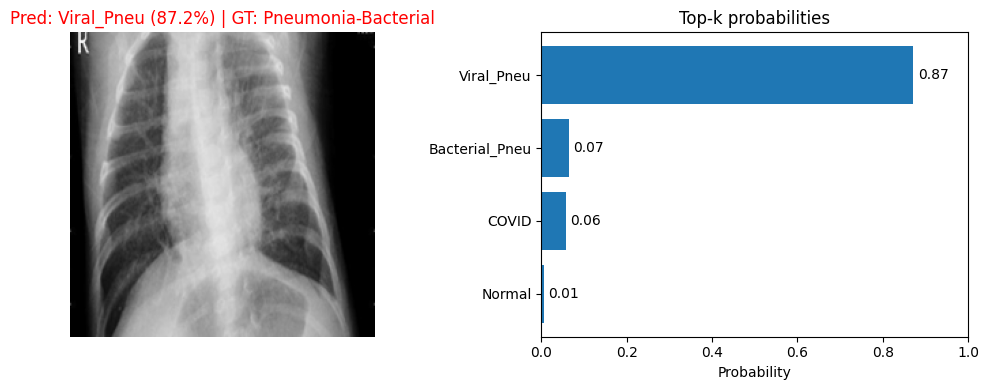

Top-1: Viral_Pneu  (conf: 0.872)
Viral_Pneu           : 0.872
Bacterial_Pneu       : 0.065
COVID                : 0.057
Normal               : 0.005


In [16]:
# Example usage:
# If you know the ground-truth class for coloring (optional), pass it via true_label="Viral_Pneu" etc.
predict_with_savedmodel(
    "../TrainDB/CuratedDB_train_test/Pneumonia-Bacterial/Pneumonia-Bacterial (101).jpg",
    show_topk=5,
    true_label=None,  # leave None to auto-infer from folder name
    save_fig_path=os.path.join(MODEL_DIR, "inference_preview.png")
)
# Paper to Product/TrainDB/CuratedDB_train_test/Pneumonia-Bacterial/Pneumonia-Bacterial (101).jpg